In [62]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pyarrow as pa
import pyarrow.parquet as pq
import itertools
import re

In [313]:
gender_cp = pd.read_parquet('./data/gender_complete_pooling.parquet')
ethnicity_cp = pd.read_parquet('./data/ethnicity_complete_pooling.parquet')
adjusted_cp = pd.read_parquet('./data/adjusted_complete_pooling.parquet')

gender_np = pd.read_parquet('./data/gender_no_pooling.parquet')
ethnicity_np = pd.read_parquet('./data/ethnicity_no_pooling.parquet')
adjusted_np = pd.read_parquet('./data/adjusted_no_pooling.parquet')

gender_ml = pd.read_parquet('./data/gender_multilevel.parquet')
ethnicity_ml = pd.read_parquet('./data/ethnicity_multilevel.parquet')
adjusted_ml = pd.read_parquet('./data/adjusted_multilevel.parquet')

In [314]:
df = pd.read_csv('./data/writing_center_v2.csv')

In [315]:
male = gender_np.filter(like='beta_Gender_Male')
female = gender_np.filter(like='beta_Gender_Female')
white = ethnicity_np.filter(like='beta_Ethnicity_White')
asian = ethnicity_np.filter(like='beta_Ethnicity_Asian')
hispanic = ethnicity_np.filter(like='beta_Ethnicity_Hispanic')
mixed = ethnicity_np.filter(like='beta_Ethnicity_Mixed')

male_ml = gender_ml.filter(like='beta_Gender_Male').filter(like='e[')
female_ml = gender_ml.filter(like='beta_Gender_Female').filter(like='e[')
white_ml = ethnicity_ml.filter(like='beta_Ethnicity_White').filter(like='e[')
asian_ml = ethnicity_ml.filter(like='beta_Ethnicity_Asian').filter(like='n[')
hispanic_ml = ethnicity_ml.filter(like='beta_Ethnicity_Hispanic').filter(like='c[')
mixed_ml = ethnicity_ml.filter(like='beta_Ethnicity_Mixed').filter(like='d[')

In [282]:
male_a = adjusted_np.filter(like='beta_Gender_Male')
female_a = adjusted_np.filter(like='beta_Gender_Female')
white_a = adjusted_np.filter(like='beta_Ethnicity_White')
asian_a = adjusted_np.filter(like='beta_Ethnicity_Asian')
hispanic_a = adjusted_np.filter(like='beta_Ethnicity_Hispanic')
mixed_a = adjusted_np.filter(like='beta_Ethnicity_Mixed')

male_a_ml = adjusted_ml.filter(like='beta_Gender_Male').filter(like='e[')
female_a_ml = adjusted_ml.filter(like='beta_Gender_Female').filter(like='e[')
white_a_ml = adjusted_ml.filter(like='beta_Ethnicity_White').filter(like='e[')
asian_a_ml = adjusted_ml.filter(like='beta_Ethnicity_Asian').filter(like='n[')
hispanic_a_ml = adjusted_ml.filter(like='beta_Ethnicity_Hispanic').filter(like='c[')
mixed_a_ml = adjusted_ml.filter(like='beta_Ethnicity_Mixed').filter(like='d[')

In [316]:
def calculate_std_feature(df):
    result_dict = {'instructor_num': None,
                   'std_': None 
                   } 
    nums = []
    stds = []
    for teacher in df.columns:
        instructor_num = re.findall(r'\[(\d+)\]', teacher)
        instructor_num = instructor_num[0] if instructor_num else None
        std = df[teacher].std()
        
        nums.append(instructor_num)
        stds.append(std)
        
        
    result_dict['instructor_num'] = nums
    result_dict['std_'] = stds
        
    result_df = pd.DataFrame(result_dict)
    
    return result_df

In [317]:
instructor_count = pd.DataFrame(df.groupby('Instructor_ID').size())
instructor_count = instructor_count.reset_index()
instructor_count.rename(columns={0: 'count'}, inplace=True)

instructor_idxs, instructors = pd.factorize(df.Instructor_ID)
df['instructor_num'] = instructor_idxs
instructor_map = df[['Instructor_ID', 'instructor_num']].drop_duplicates()
instructor_map = pd.merge(instructor_map, instructor_count)

In [318]:
#Non adjusted
for _ in [male, female, white, asian, hispanic, mixed]:
    name = re.findall(r'beta_([^_]+)_(\w+)', str(_.columns[0]))[0][1]
    res = calculate_std_feature(_)
    res.rename(columns={'std_': 'std_'+name}, inplace=True)
    res['instructor_num'] = pd.to_numeric(res['instructor_num'], errors='coerce', downcast='integer')
    instructor_map = pd.merge(instructor_map, res, on='instructor_num', how='left')
    
for _ in [male_ml, female_ml, white_ml, asian_ml, hispanic_ml, mixed_ml]:
    name = re.findall(r'beta_([^_]+)_(\w+)', str(_.columns[0]))[0][1]+'_ml'
    res = calculate_std_feature(_)
    res.rename(columns={'std_': 'std_'+name}, inplace=True)
    res['instructor_num'] = pd.to_numeric(res['instructor_num'], errors='coerce', downcast='integer')
    instructor_map = pd.merge(instructor_map, res, on='instructor_num', how='left')

In [284]:
#Adjusted
# for _ in [male_a, female_a, white_a, asian_a, hispanic_a, mixed_a]:
#     name = re.findall(r'beta_([^_]+)_(\w+)', str(_.columns[0]))[0][1]
#     res = calculate_std_feature(_)
#     res.rename(columns={'std_': 'std_'+name}, inplace=True)
#     res['instructor_num'] = pd.to_numeric(res['instructor_num'], errors='coerce', downcast='integer')
#     instructor_map = pd.merge(instructor_map, res, on='instructor_num', how='left')
    
# for _ in [male_a_ml, female_a_ml, white_a_ml, asian_a_ml, hispanic_a_ml, mixed_a_ml]:
#     name = re.findall(r'beta_([^_]+)_(\w+)', str(_.columns[0]))[0][1]+'_ml'
#     res = calculate_std_feature(_)
#     res.rename(columns={'std_': 'std_'+name}, inplace=True)
#     res['instructor_num'] = pd.to_numeric(res['instructor_num'], errors='coerce', downcast='integer')
#     instructor_map = pd.merge(instructor_map, res, on='instructor_num', how='left')

# Plot

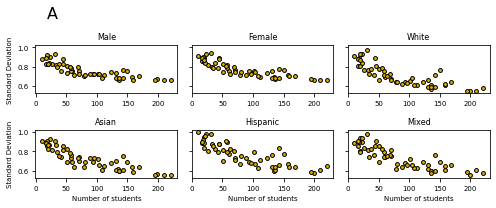

In [287]:
categories = ['std_Male', 'std_Female', 'std_White', 'std_Asian', 'std_Hispanic', 'std_Mixed']

nrows, ncols = 2, 3

# Create subplots with shared y-axis
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(7, 3), sharey=True)

# Flatten the axes for easy iteration
axes = axes.flatten()

# List of categories
categories = ['std_Male', 'std_Female', 'std_White', 'std_Asian', 'std_Hispanic', 'std_Mixed']

i = 0
# Iterate over subplots and plot each category
for ax, category in zip(axes, categories):
    ax.scatter(instructor_map['count'], instructor_map[category], color="#E1AF00", edgecolor='black',s=15)
    ax.set_title(category.split('_')[-1], fontsize=8)
    if i == 0:
        ax.set_xlabel('')
        ax.set_ylabel('Standard Deviation', fontsize=7)
        
    elif i == 1:
        ax.set_xlabel('')
        ax.set_ylabel('')
    
    elif i == 2:
        ax.set_xlabel('')
        ax.set_ylabel('')
        
    elif i == 3:
        ax.set_xlabel('Number of students', fontsize=7)
        ax.set_ylabel('Standard Deviation', fontsize=7)
        
    elif i == 4:
        ax.set_xlabel('Number of students', fontsize=7)
        ax.set_ylabel('')
        
    elif i== 5:
        ax.set_xlabel('Number of students', fontsize=7)
        ax.set_ylabel('')
    
     
    elif i== 6:
        ax.set_xlabel('Number of students', fontsize=7)
        ax.set_ylabel('')
    i += 1

    
    ax.tick_params(axis='both', which='both', labelsize=7)
    


#plt.suptitle('A', x=0.1, y=0.95, ha='left', fontsize=16)
# Adjust layout for better spacing
plt.tight_layout()

#plt.savefig('output_a.svg', format='svg')

# Show the plot
plt.show()

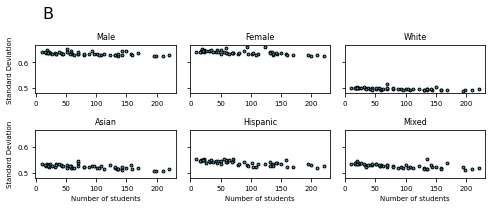

In [286]:
categories = ['std_Male_ml', 'std_Female_ml', 'std_White_ml', 'std_Asian_ml', 'std_Hispanic_ml', 'std_Mixed_ml']

nrows, ncols = 2, 3

# Create subplots with shared y-axis
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(7, 3), sharey=True)

# Flatten the axes for easy iteration
axes = axes.flatten()

# Iterate over subplots and plot each category
i = 0
for ax, category in zip(axes, categories):
    ax.scatter(instructor_map['count'], instructor_map[category], color="#3B9AB2", edgecolor='black',s=8)
    ax.set_title(category.split('_')[-2], fontsize=8)
    if i == 0:
        ax.set_xlabel('')
        ax.set_ylabel('Standard Deviation', fontsize=7)
        
    elif i == 1:
        ax.set_xlabel('')
        ax.set_ylabel('')
    
    elif i == 2:
        ax.set_xlabel('')
        ax.set_ylabel('')
        
    elif i == 3:
        ax.set_xlabel('Number of students', fontsize=7)
        ax.set_ylabel('Standard Deviation', fontsize=7)
        
    elif i == 4:
        ax.set_xlabel('Number of students', fontsize=7)
        ax.set_ylabel('')
        
    elif i== 5:
        ax.set_xlabel('Number of students', fontsize=7)
        ax.set_ylabel('')
    
     
    elif i== 6:
        ax.set_xlabel('Number of students', fontsize=7)
        ax.set_ylabel('')
    i += 1

    
    ax.tick_params(axis='both', which='both', labelsize=7)
    



plt.suptitle('B', x=0.1, y=0.95, ha='left', fontsize=16)
# Adjust layout for better spacing
plt.tight_layout()

plt.savefig('output2_a.svg', format='svg')

# Show the plot
plt.show()